# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010)

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
df.shape

(41188, 21)

In [6]:
df.y.value_counts(normalize=True).round(2)

y
no     0.89
yes    0.11
Name: proportion, dtype: float64

In [7]:
df.duplicated().sum()

np.int64(12)

In [8]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Observation about the dataset

1. None of the columns have missing values.
2. There are no duplicate entries. 
3. There are 21 features - 10 numeric and 11 categorical
4. The categorical features can be updated as follows:
   a. Three features, `default`, `housing`, and `loan` are yes/no values and can be converted to numeric 1/0 if needed
   b. Two features, `month,` and `day_of_week,` can be converted to a number, 1..12 and 1..7 respectively.
   c. The rest of the categorical features can be encoded with One Hot Encoding
5. The numeric features can be scaled using StandardScalar.
    

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective
The business objective is to improve the effectiveness of a Portuguese bank's marketing efforts conducted over the telephone. The goal of the marketing effort is to get the customer to subscribe to a long-term product and reduce the cost of these efforts (customer acquisition cost). The primary objective of this assignment is to build a predictive model that can classify whether a customer contacted on the phone as part of this marketing campaign will sign up for the deposit product. This will help the bank to focus on customers with an excellent chance to sign up, to increase the percentage of customers who start a term deposit as a result of the campaign (effectiveness), and reduce the acquisition cost. 

This classification problem with the objective to identify the most predictive features influencing the classification outcome. The solution will compare the performance of different classification algorithms - k-nearest neighbors, logistic regression, decision trees, and support vector machines, to determine which model best predicts client subscription. 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [9]:
# The test dataset did not have any duplicates or NaNs. 
# I am including these here in case a different data set has these issues
# drop any duplicates
df = df.drop_duplicates()
# Drop rows with missing values and reset the index
df = df.dropna().reset_index(drop=True)

In [10]:
#Remap labels yes and no in feature `y` to 1 or 0
df['y'] = df['y'].map({'yes':1, 'no':0})
print(df['y'].value_counts())
df.head()

y
0    36537
1     4639
Name: count, dtype: int64


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [11]:
#Using only the columns 1-7 for modeling
transformer = make_column_transformer(
    (
        (OneHotEncoder(drop = 'if_binary'),['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact'])
    ), remainder=StandardScaler()
    )
transformer

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact'])])

In [12]:
X = transformer.fit_transform(df[['age','job', 'marital', 'education', 'default', 'housing', 'loan', 'contact']])
y = df['y']
print("X", X.shape)
print("y", y.shape)

X (41176, 35)
y (41176,)


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.
Since the dataset is imbalanced, use stratify parameter to keep the proportion of two  classes in `y` in the test and train sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (28823, 35)
X_test shape:  (12353, 35)
y_train shape:  (28823,)
y_test shape:  (12353,)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [14]:
dummy_estimator = DummyClassifier().fit(X_train, y_train)
dummy_train_score = dummy_estimator.score(X_train, y_train)
dummy_test_score = dummy_estimator.score(X_test, y_test)
print('Dummy Classifier Train Score {}'.format(dummy_train_score))
print('Dummy Classifier Test Score  {}'.format(dummy_test_score))

# Build confusion matrix, and also y predict
y_pred_dummy = dummy_estimator.predict(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
conf_matrix_dummy = confusion_matrix(y_test, y_pred_dummy)
class_report_dummy = classification_report(y_test, y_pred_dummy)

print("Dummy Classifier Performance:")
print(f"Accuracy: {accuracy_dummy}")
print("Confusion Matrix:\n", conf_matrix_dummy)
print("Classification Report:\n", class_report_dummy)

Dummy Classifier Train Score 0.8873469104534573
Dummy Classifier Test Score  0.88731482231037
Dummy Classifier Performance:
Accuracy: 0.88731482231037
Confusion Matrix:
 [[10961     0]
 [ 1392     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     10961
           1       0.00      0.00      0.00      1392

    accuracy                           0.89     12353
   macro avg       0.44      0.50      0.47     12353
weighted avg       0.79      0.89      0.83     12353




##### Note
The baseline model's performance is 88.76%. The baseline model is a dummy classifier that makes the majority prediction (in this case a 0 or no) for all rows and calculates accuracy. This is plotted below in the confusion matrix.

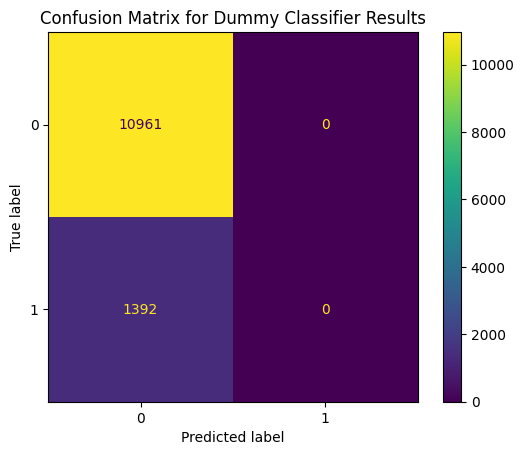

In [15]:
confusionmatrix_dummy = ConfusionMatrixDisplay.from_estimator(dummy_estimator, X_test, y_test)
confusionmatrix_dummy.ax_.set_title('Confusion Matrix for Dummy Classifier Results')
plt.show()

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [16]:
simple_lr_estimator = LogisticRegression(max_iter=1000).fit(X_train, y_train)

### Problem 9: Score the Model

What is the accuracy of your model?

In [17]:
lr_train_score = simple_lr_estimator.score(X_train, y_train)
lr_test_score = simple_lr_estimator.score(X_test, y_test)
print('Simple Logistic Regression Model Train Score = {}'.format(lr_train_score))
print('Simple Logistic Regression Model Test Score  = {}'.format(lr_test_score))

# Build confusion matrix, and also y predict
y_pred_simple_lr = simple_lr_estimator.predict(X_test)
accuracy_simple_lr = accuracy_score(y_test, y_pred_simple_lr)
conf_matrix_simple_lr = confusion_matrix(y_test, y_pred_simple_lr)
class_report_simple_lr = classification_report(y_test, y_pred_simple_lr)

print("Dummy Classifier Performance:")
print(f"Accuracy: {accuracy_simple_lr}")
print("Confusion Matrix:\n", conf_matrix_simple_lr)
print("Classification Report:\n", class_report_simple_lr)

Simple Logistic Regression Model Train Score = 0.8873469104534573
Simple Logistic Regression Model Test Score  = 0.88731482231037
Dummy Classifier Performance:
Accuracy: 0.88731482231037
Confusion Matrix:
 [[10961     0]
 [ 1392     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     10961
           1       0.00      0.00      0.00      1392

    accuracy                           0.89     12353
   macro avg       0.44      0.50      0.47     12353
weighted avg       0.79      0.89      0.83     12353



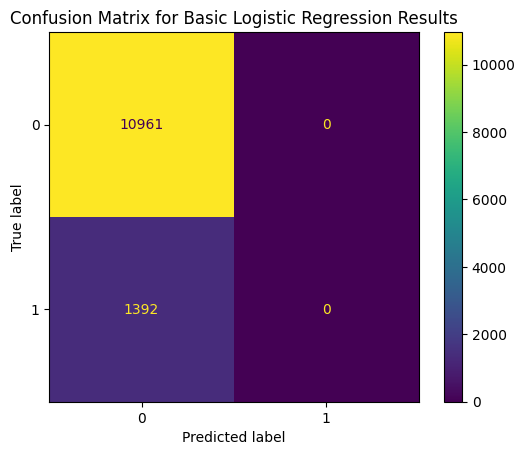

In [18]:
confusionmatrix_simple_lr = ConfusionMatrixDisplay.from_estimator(simple_lr_estimator, X_test, y_test)
confusionmatrix_simple_lr.ax_.set_title('Confusion Matrix for Basic Logistic Regression Results')
plt.show()

Curiously, `LogisticRegression` predicted exactly the same values as the `DummyClassifier`, resulting in the exact same scores.

#### Build a basic Decision Tree Classifier Model and Score it

In [19]:
simple_dtree = DecisionTreeClassifier().fit(X_train, y_train)

In [20]:
simple_dtree_train_score = simple_dtree.score(X_train, y_train)
simple_dtree_test_score = simple_dtree.score(X_test, y_test)
print('Simple Decision Tree Train Score = {}'.format(simple_dtree_train_score))
print('Simple Decision Tree Model Test Score  = {}'.format(simple_dtree_test_score))

# Build confusion matrix, and also y predict
y_pred_simple_dtree = simple_dtree.predict(X_test)
accuracy_simple_dtree = accuracy_score(y_test, y_pred_simple_dtree)
conf_matrix_simple_dtree = confusion_matrix(y_test, y_pred_simple_dtree)
class_report_simple_dtree = classification_report(y_test, y_pred_simple_dtree)

print("Dummy Classifier Performance:")
print(f"Accuracy: {accuracy_simple_dtree}")
print("Confusion Matrix:\n", conf_matrix_simple_dtree)
print("Classification Report:\n", class_report_simple_dtree)

Simple Decision Tree Train Score = 0.9263782396003192
Simple Decision Tree Model Test Score  = 0.8590625758924958
Dummy Classifier Performance:
Accuracy: 0.8590625758924958
Confusion Matrix:
 [[10470   491]
 [ 1250   142]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92     10961
           1       0.22      0.10      0.14      1392

    accuracy                           0.86     12353
   macro avg       0.56      0.53      0.53     12353
weighted avg       0.82      0.86      0.84     12353



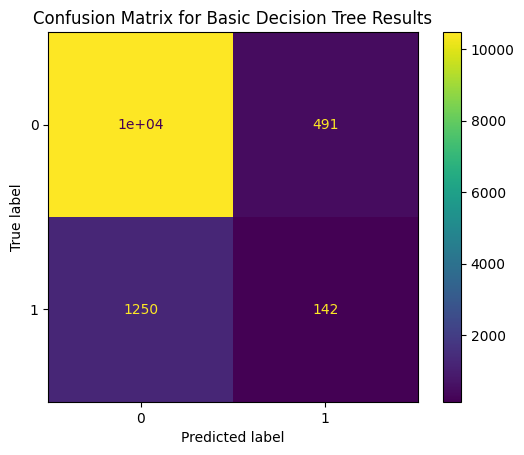

In [21]:
confusionmatrix_simple_dtree = ConfusionMatrixDisplay.from_estimator(simple_dtree, X_test, y_test)
confusionmatrix_simple_dtree.ax_.set_title('Confusion Matrix for Basic Decision Tree Results')
plt.show()

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [22]:
estimators = {'Logistic Regression':LogisticRegression(max_iter = 1000),
              'Decision Tree':DecisionTreeClassifier(),
              'Support Vector Machine':SVC(),
              'K Nearest Neighbors':KNeighborsClassifier()}
scores_dict = {'Model':[], 'Train Time':[], 'Train Accuracy':[], 'Test Accuracy':[]}

for estimator in estimators:
  start = time.time()
  fit_estimator = estimators[estimator].fit(X_train, y_train)
  stop = time.time()
  scores_dict['Model'].append(estimator)
  scores_dict['Train Accuracy'].append(fit_estimator.score(X_train, y_train))
  scores_dict['Test Accuracy'].append(fit_estimator.score(X_test, y_test))
  scores_dict['Train Time'].append(stop - start)

scores_dict_df = pd.DataFrame(scores_dict)
scores_dict_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.077768,0.887347,0.887315
1,Decision Tree,1.080166,0.926378,0.859144
2,Support Vector Machine,95.564823,0.888214,0.887234
3,K Nearest Neighbors,0.020246,0.892794,0.879786


The results indicate that with the first seven features and default parameters the four classifier methods do not improve much over the baseline. The does not meet the objectives of this project. The models have to be improved. 

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Feature Engineering & Exploration

The models with the bank information have not yielded results better than the baseline model. 
Hence, we have to do some exploratory data analysis (EDA). 
The data columns were plotted and from this and with a few trials I found the following to yield better results than others. 

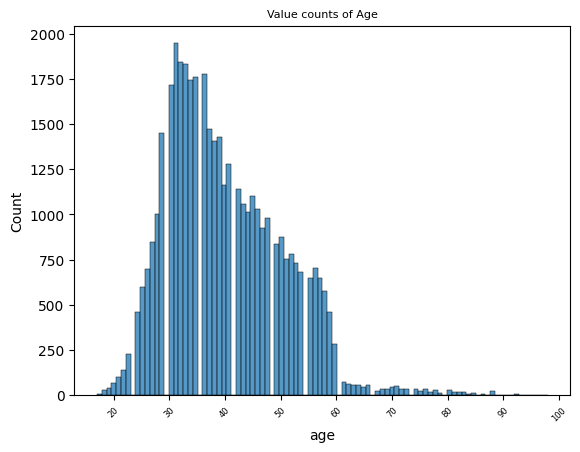

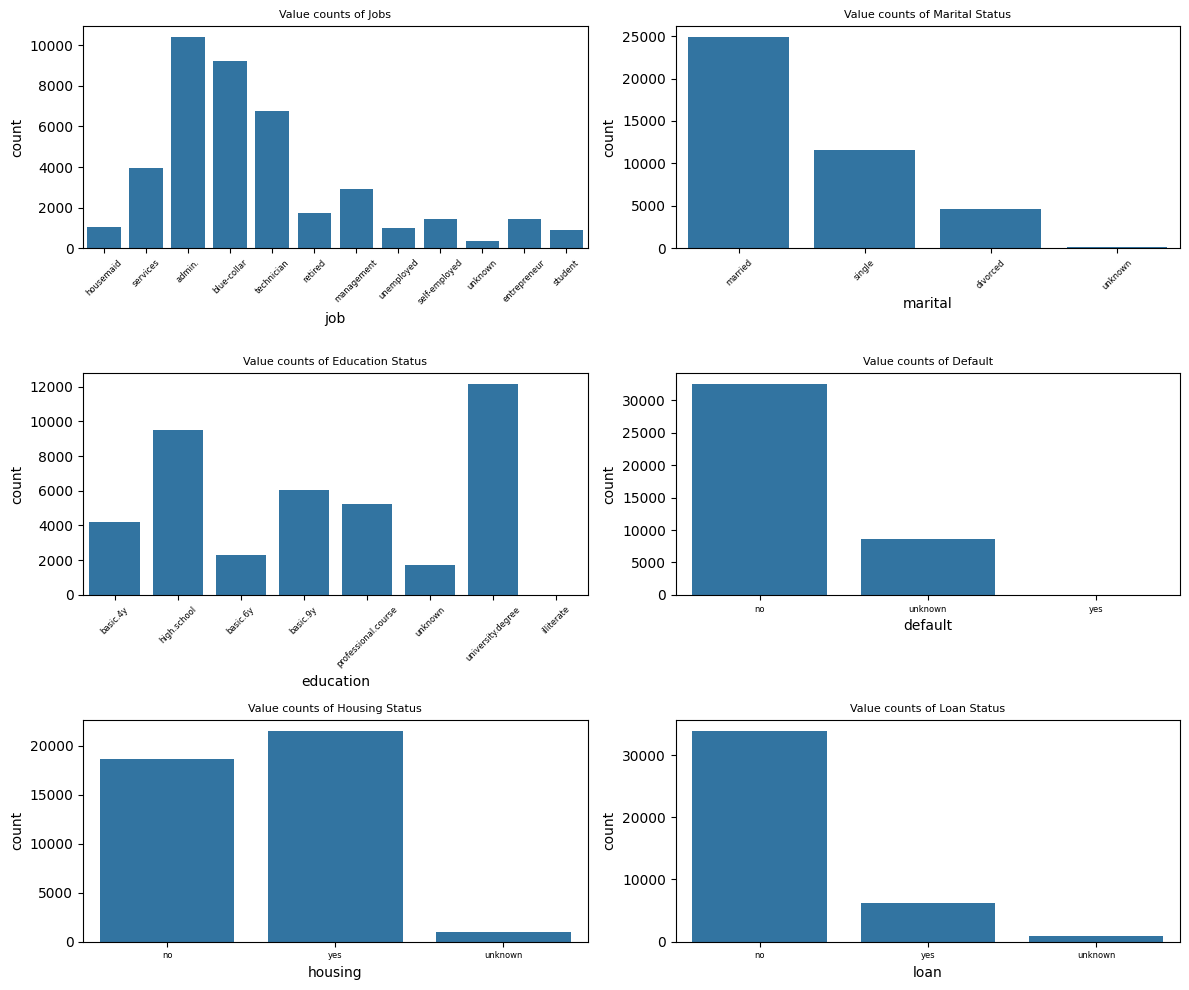

In [23]:
explore_df = df

# Plot age job marital education default housing loan
sns.histplot(data=explore_df, x='age')
plt.title('Value counts of Age', fontsize=8)
plt.tick_params(axis='x', rotation=45, labelsize=6)
plt.show()

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
sns.countplot(data=explore_df, x='job', ax=axes[0, 0])
axes[0,0].set_title('Value counts of Jobs', fontsize=8)
axes[0,0].tick_params(axis='x', rotation=45, labelsize=6)

sns.countplot(data=explore_df, x='marital', ax=axes[0, 1])
axes[0,1].set_title('Value counts of Marital Status', fontsize=8)
axes[0,1].tick_params(axis='x', rotation=45, labelsize=6)

sns.countplot(data=explore_df, x='education', ax=axes[1, 0])
axes[1,0].set_title('Value counts of Education Status', fontsize=8)
axes[1,0].tick_params(axis='x', rotation=45, labelsize=6)

sns.countplot(data=explore_df, x='default', ax=axes[1, 1])
axes[1,1].set_title('Value counts of Default', fontsize=8)
axes[1,1].tick_params(axis='x', labelsize=6)

sns.countplot(data=explore_df, x='housing', ax=axes[2, 0])
axes[2,0].set_title('Value counts of Housing Status', fontsize=8)
axes[2,0].tick_params(axis='x', labelsize=6)

sns.countplot(data=explore_df, x='loan', ax=axes[2, 1])
axes[2,1].set_title('Value counts of Loan Status', fontsize=8)
axes[2,1].tick_params(axis='x', labelsize=6)
plt.tight_layout()
plt.show()


##### Exploratory data analysis in the features

Simplifying some features by making them binary
1. `is_employed`: map all employed types to 1. all others mapped to 0
2. `is_married`: map married to 1. divorced, single and unknown  to 0
3. `housing`: map yes to 1. no and unknown to 0
4. `loan`: map yes to 1. no and unknown to 0

One feature `age` is better if map it to buckets of 10 years

In [24]:
explore_df['is_employed'] = explore_df['job'].map({'admin.':1,
                                'blue-collar': 1,
                                'technician': 1,
                                'services': 1,
                                'management': 1,
                                'retired': 0,
                                'entrepreneur': 1,
                                'self-employed': 1,
                                'housemaid': 1,
                                'unemployed': 0,
                                'student': 0,
                                'unknown': 0})

# print(explore_df['is_employed'].unique())
# print(explore_df['is_employed'].dtype)
# print(explore_df['is_employed'].isna().sum())
# print(explore_df['is_employed'].value_counts())

In [25]:
explore_df['is_married'] = explore_df['marital'].map({'divorced': 0,
                                      'married': 1,
                                      'single': 0,
                                      'unknown': 0})

# print(explore_df['is_married'].unique())
# print(explore_df['is_married'].dtype)
# print(explore_df['is_married'].isna().sum())
# print(explore_df['is_married'].value_counts())

In [26]:
explore_df['housing'] = explore_df['housing'].map({'no': 0,
                                                   'yes': 1,
                                                   'unknown': 0})
# print(explore_df['housing'].unique())
# print(explore_df['housing'].dtype)
# print(explore_df['housing'].isna().sum())
# print(explore_df['housing'].value_counts())

In [27]:
explore_df['loan'] = explore_df['loan'].map({'no': 0,
                                             'yes': 1,
                                             'unknown': 0})
# print(explore_df['loan'].unique())
# print(explore_df['loan'].dtype)
# print(explore_df['loan'].isna().sum())
# print(explore_df['loan'].value_counts())

In [28]:
explore_df['age_cat'] = pd.cut(df['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, np.inf])
# print(explore_df['age_cat'].unique())
# print(explore_df['age_cat'].dtype)
# print(explore_df['age_cat'].isna().sum())
# print(explore_df['age_cat'].value_counts())

Draw all the plots once more

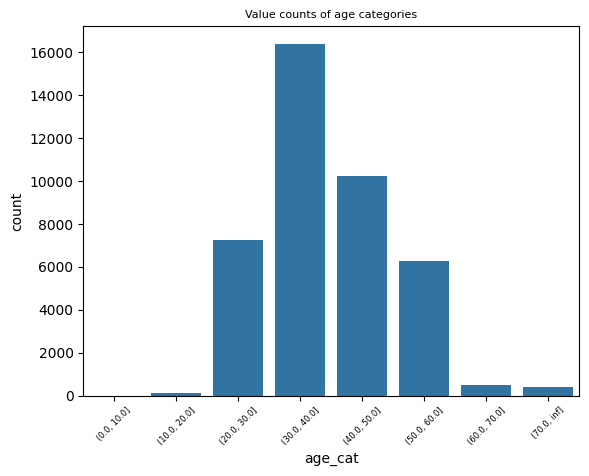

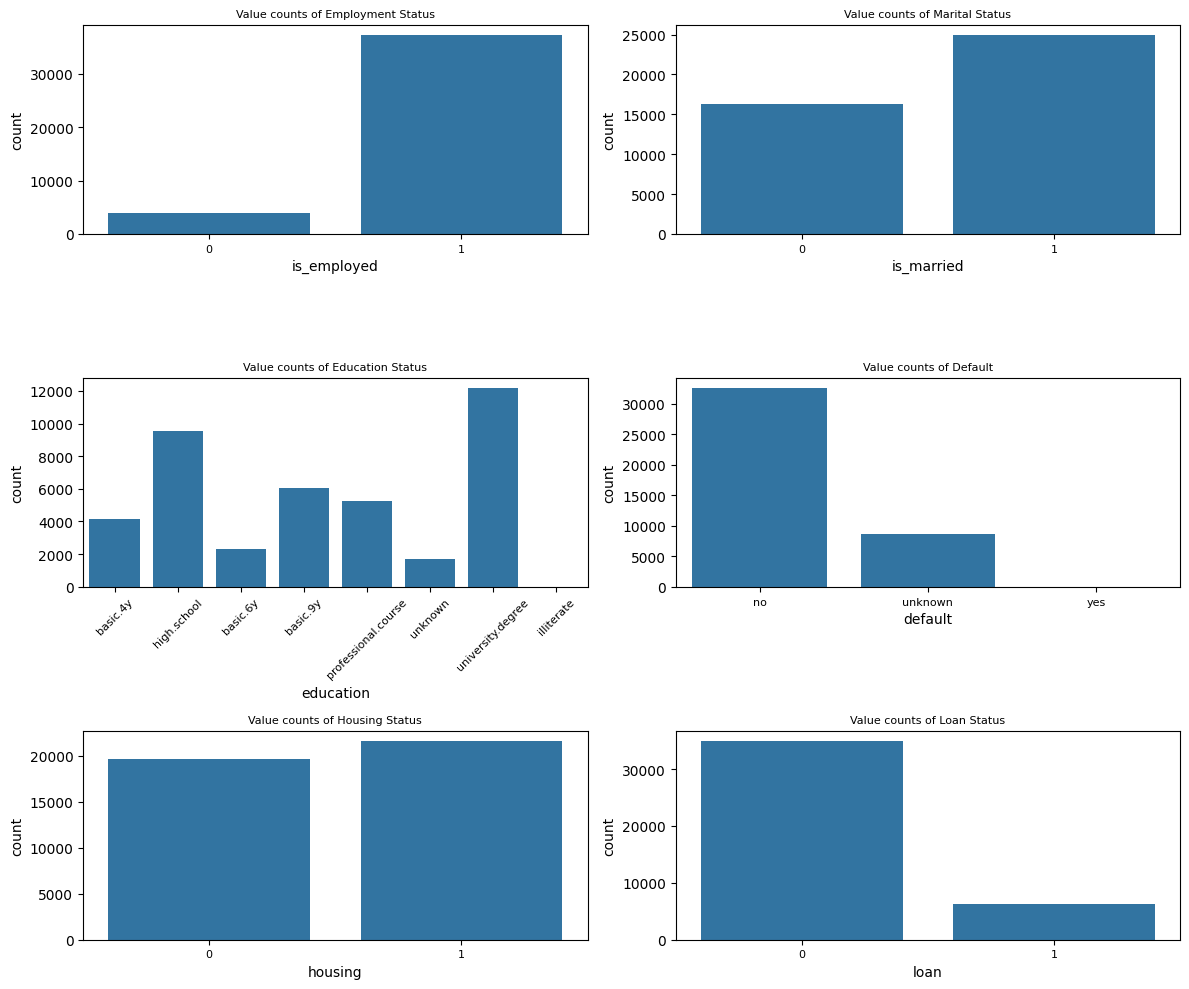

In [29]:
sns.countplot(data=explore_df, x='age_cat')
plt.title('Value counts of age categories', fontsize=8)
plt.tick_params(axis='x', rotation=45, labelsize=6)

plt.show()

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
# fig, axes = plt.subplots(3, 2)

sns.countplot(data=explore_df, x='is_employed', ax=axes[0, 0])
axes[0,0].set_title('Value counts of Employment Status', fontsize=8)
axes[0,0].tick_params(axis='x', labelsize=8)

sns.countplot(data=explore_df, x='is_married', ax=axes[0, 1])
axes[0,1].set_title('Value counts of Marital Status', fontsize=8)
axes[0,1].tick_params(axis='x', labelsize=8)

sns.countplot(data=explore_df, x='education', ax=axes[1, 0])
axes[1,0].set_title('Value counts of Education Status', fontsize=8)
axes[1,0].tick_params(axis='x', rotation=45, labelsize=8)

sns.countplot(data=explore_df, x='default', ax=axes[1, 1])
axes[1,1].set_title('Value counts of Default', fontsize=8)
axes[1,1].tick_params(axis='x', labelsize=8)

sns.countplot(data=explore_df, x='housing', ax=axes[2, 0])
axes[2,0].set_title('Value counts of Housing Status', fontsize=8)
axes[2,0].tick_params(axis='x', labelsize=8)

sns.countplot(data=explore_df, x='loan', ax=axes[2, 1])
axes[2,1].set_title('Value counts of Loan Status', fontsize=8)
axes[2,1].tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

##### Dropping columns that don't have useful data
1.  `default`: There are only a large number of unknowns and only 3 yes's. Let's drop this column
2.  `education`: The results improved without `education`. So, dropping that column. Look at this for future work

After this, split the data set into train and test

In [30]:
transformer = make_column_transformer(
    (
        (OneHotEncoder(),['age_cat'])
    ), remainder='passthrough'
    )

X = transformer.fit_transform(df[['age_cat', 'is_employed', 'is_married', 'housing', 'loan']])
y = df['y']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

##### Build the 4 estimators LR, DT, SVN and KNN and score their run time and accuracy

In [32]:
estimators = {'Logistic Regression': LogisticRegression(max_iter = 1000),
              'Decision Tree': DecisionTreeClassifier(),
              'Support Vector Machine': SVC(),
              'K Nearest Neighbors': KNeighborsClassifier()}
scores_dict = {'Model':[], 'Train Time':[], 'Train Accuracy':[], 'Test Accuracy':[]}
import time

for estimator in estimators:
  start = time.time()
  fit_estimator = estimators[estimator].fit(X_train, y_train)
  stop = time.time()
  scores_dict['Model'].append(estimator)
  scores_dict['Train Accuracy'].append(fit_estimator.score(X_train, y_train))
  scores_dict['Test Accuracy'].append(fit_estimator.score(X_test, y_test))
  scores_dict['Train Time'].append(stop - start)
results = pd.DataFrame(scores_dict)
results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.098095,0.886722,0.887881
1,Decision Tree,0.040959,0.888041,0.886505
2,Support Vector Machine,11.722549,0.887382,0.887396
3,K Nearest Neighbors,0.103445,0.886133,0.886505


##### Adding more features from the dataset
The results have not budged much with the above trials.
Let us try adding more features to the dataset.

In [33]:
# Start from explore_df
df_all = explore_df

transformer = make_column_transformer(
    (OneHotEncoder(drop = 'if_binary'),['age_cat', 'contact', 'month', 'day_of_week', 'poutcome']),
    (StandardScaler(), ['duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                        'cons.price.idx', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
                        'nr.employed']),
    remainder='passthrough')

X = transformer.fit_transform(df_all[['age_cat', 'is_employed', 'is_married', 'housing', 'loan',
                                     'contact', 'month', 'day_of_week', 'poutcome',
                                     'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                                     'cons.price.idx', 'cons.conf.idx', 'euribor3m',
                                     'nr.employed']])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=42)

In [34]:
estimators = {'Logistic Regression':LogisticRegression(max_iter = 1000),
              'Decision Tree':DecisionTreeClassifier(),
              'Support Vector Machine':SVC(),
              'K Nearest Neighbors':KNeighborsClassifier()}
scores_dict = {'Model':[], 'Train Time':[], 'Train Accuracy':[], 'Test Accuracy':[]}
import time

for estimator in estimators:
  start = time.time()
  fit_estimator = estimators[estimator].fit(X_train, y_train)
  stop = time.time()
  scores_dict['Model'].append(estimator)
  scores_dict['Train Accuracy'].append(fit_estimator.score(X_train, y_train))
  scores_dict['Test Accuracy'].append(fit_estimator.score(X_test, y_test))
  scores_dict['Train Time'].append(stop - start)

results = pd.DataFrame(scores_dict)
results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.612350,0.911529,0.908524
1,Decision Tree,0.282974,0.999965,0.883915
2,Support Vector Machine,21.961259,0.919127,0.911358
3,K Nearest Neighbors,0.001256,0.930576,0.902777


In [35]:
results = pd.DataFrame(scores_dict)
results

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.612350,0.911529,0.908524
1,Decision Tree,0.282974,0.999965,0.883915
2,Support Vector Machine,21.961259,0.919127,0.911358
3,K Nearest Neighbors,0.001256,0.930576,0.902777


#### Hyperparameter tuning and grid search

The right feature set and the transformations for best results have been identified.  
Now  tune the hyper parameters using grid search.

In [36]:
estimators = {'Logistic Regression':LogisticRegression(),
              'Decision Tree':DecisionTreeClassifier(),
              'Support Vector Machine':SVC(),
              'K Nearest Neighbors':KNeighborsClassifier()}
scores_dict = {'Model':[], 'Best Estimator': [], 'Train Time':[], 'Train Accuracy':[], 'Test Accuracy':[]}
param_grid = {}
param_grid['K Nearest Neighbors'] = {'n_neighbors':np.arange(1,30)}
param_grid['Logistic Regression'] = {'max_iter':[2,4,100,1000]}
param_grid['Decision Tree'] = {'max_depth':[0,4,10,100]}
param_grid['Support Vector Machine'] = {'kernel':['linear', 'rbf'], 'gamma': [-3,0, 3,30]}

import time
for estimator in estimators:
  model = estimators[estimator].fit(X_train, y_train)
  gscv = GridSearchCV(estimator=model, param_grid = param_grid[estimator], cv=5)
  gscv.fit(X_train, y_train)


  scores_dict['Model'].append(estimator)
  scores_dict['Best Estimator'].append(gscv.best_estimator_)
  scores_dict['Train Accuracy'].append(gscv.best_estimator_.score(X_train, y_train))
  scores_dict['Test Accuracy'].append(gscv.best_estimator_.score(X_test, y_test))
  scores_dict['Train Time'].append(gscv.cv_results_['mean_fit_time'].mean())

results = pd.DataFrame(scores_dict)
results

,Model,Best Estimator,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,LogisticRegression(),0.318884,0.911529,0.908524
1,Decision Tree,DecisionTreeClassifier(max_depth=4),0.158806,0.914617,0.910791
2,Support Vector Machine,"SVC(gamma=0, kernel='linear')",52.330370,0.905041,0.904881
3,K Nearest Neighbors,KNeighborsClassifier(n_neighbors=np.int64(29)),0.012608,0.912049,0.907715


Based on the Grid Search, Decision Tree with max_depth of 4 provided the highest Train and Test accuracy with minimal training time.  
This model beats the accuracy of the baseline model by around 3%.

#### Adjusting the performance metric

With the winning model, we can check how the model performed in terms of precision, recall and other performance measures

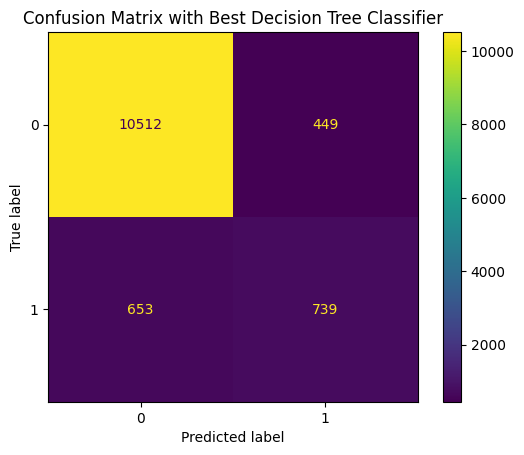

In [37]:
dtree_4 = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
disp = ConfusionMatrixDisplay.from_estimator(dtree_4, X_test, y_test)
disp.ax_.set_title('Confusion Matrix with Best Decision Tree Classifier')
plt.show()

##### Next build the ROC curve and ROC AUC score for the Decision Tree and Logistic Regression Models

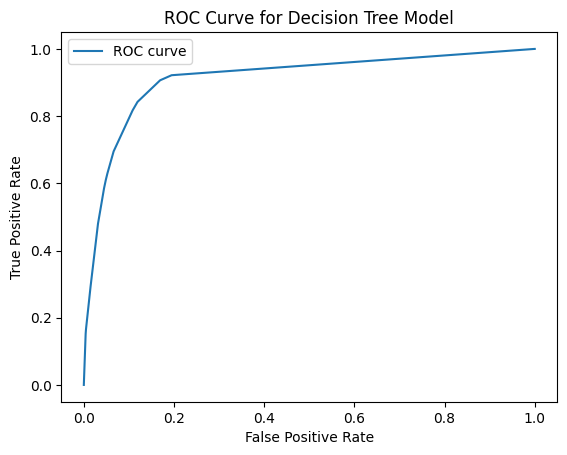

AUC: 0.911751303103712


In [38]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y, dtree_4.predict_proba(X)[:, 1])

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Model')
plt.legend()
plt.show()

# Calculate the AUC
auc = roc_auc_score(y, dtree_4.predict_proba(X)[:, 1])
print('AUC:', auc)

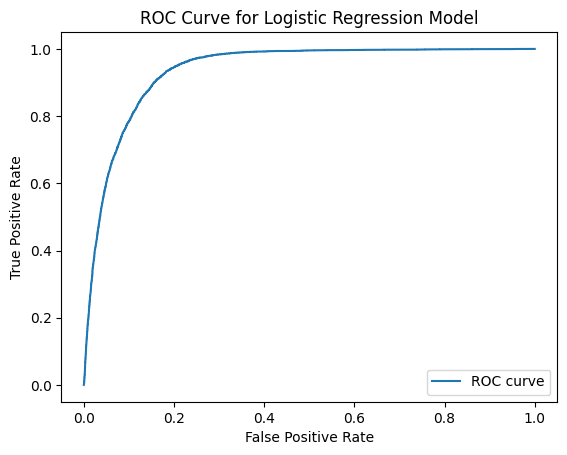

AUC: 0.9361868351590465


In [39]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_model = LogisticRegression().fit(X_train, y_train)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y, lr_model.predict_proba(X)[:, 1])

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend()
plt.show()

# Calculate the AUC
auc = roc_auc_score(y, lr_model.predict_proba(X)[:, 1])
print('AUC:', auc)

Note that the Logistic Regression model has a better AUC of 0.94 which is better than the AUC of 0.91 of the Decision Tree model, even though Decision Tree has better accuracy than Logistic Regression. 

##### Questions